In [19]:
!pip install tensorflow
!pip install opencv-python
!pip install matplotlib
!pip install Image

In [1]:
import os
import numpy as np
import cv2
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    MaxPooling2D,
    Conv2DTranspose,
    concatenate,
    BatchNormalization
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import time


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Augmenteation

Enter cropping mode: 'automatic' or 'manual': automatic
Performing automatic cropping...
4000 3808
New image resolution: (200, 200) (Width x Height)


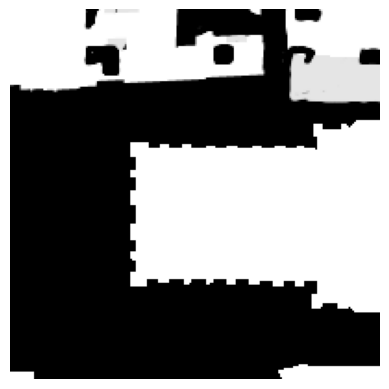

Automatically cropped image saved as /content/drive/MyDrive/Education/University/Master/BSML/satellite.png


In [ ]:
# try to crop an image yourself

def interactive_image_cropper(image_path, output_path="/content/drive/MyDrive/Education/University/Master/BSML/satellite.png"):
    # Load the image
    img = Image.open(image_path)

    mode = input("Enter cropping mode: 'automatic' or 'manual': ").strip().lower()

    if mode == "automatic":
        # Perform automatic cropping
        print("Performing automatic cropping...")
        width, height = img.size
        print(width, height)
        img = img.crop((1900, 1804, width - 1900, height - 1804))
        print(f"New image resolution: {img.size} (Width x Height)")

        # Display the cropped image
        plt.imshow(np.array(img))
        plt.axis("off")
        plt.show()

        # Save the cropped image
        img.save(output_path)
        print(f"Automatically cropped image saved as {output_path}")
        return

    elif mode == "manual":
        # Manual cropping loop
        while True:
            # Display the image and its resolution
            print(f"Current image resolution: {img.size} (Width x Height)")
            plt.imshow(np.array(img))
            plt.axis("off")
            plt.show()

            # Add a delay before clearing the plot
            time.sleep(2)  # Display the image for 2 seconds
            plt.close()    # Close the plot

            # Ask user if they want to crop or save
            print("Options: 'right', 'left', 'up', 'down' to crop, or 'ok' to save the image.")
            action = input("Your choice: ").strip().lower()

            if action == "ok":
                # Save the final image
                img.save(output_path)
                print(f"Image saved as {output_path}")
                break
            elif action in {"right", "left", "up", "down"}:
                # Ask for the number of pixels to crop
                try:
                    pixels = int(input(f"How many pixels to crop from {action}? "))
                    if pixels <= 0:
                        print("Please enter a positive number.")
                        continue
                except ValueError:
                    print("Invalid input. Please enter a valid number of pixels.")
                    continue

                # Get the current dimensions
                width, height = img.size

                # Crop based on user input
                if action == "right":
                    img = img.crop((0, 0, width - pixels, height))
                elif action == "left":
                    img = img.crop((pixels, 0, width, height))
                elif action == "up":
                    img = img.crop((0, pixels, width, height))
                elif action == "down":
                    img = img.crop((0, 0, width, height - pixels))
            else:
                print("Invalid option. Please choose 'right', 'left', 'up', 'down', or 'ok'.")
    else:
        print("Invalid mode. Please enter 'automatic' or 'manual'.")


interactive_image_cropper("/content/drive/MyDrive/Education/University/Master/BSML/Milano_mask.png")
# Milano_mask1.png
# up : 453
# down : 2155
# right: 550
# left: 500

# DATA AUGMENTATION : MILANO AND LJUBLJANA

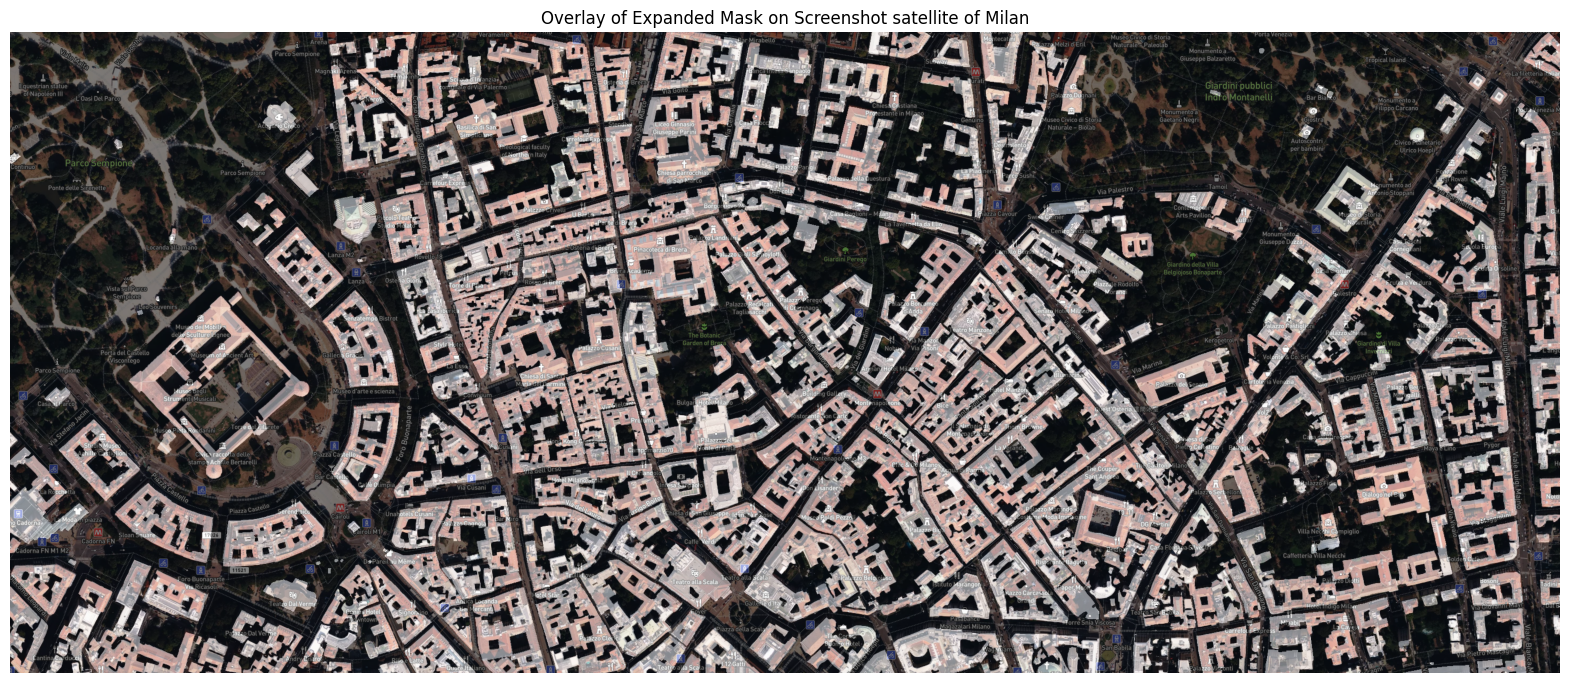

In [7]:
satellite_path = "/content/drive/MyDrive/Education/University/Master/BSML/cropped_satellite_Milano.png"
satellite = Image.open(satellite_path)

mask_path = "/content/drive/MyDrive/Education/University/Master/BSML/cropped_mask_Milano.png"
mask = Image.open(mask_path)

# Convert the screenshot to an array for overlay
satellite_array = np.array(satellite)
mask_array = np.array(mask)

# Plot the screenshot and the resized mask overlay
plt.figure(figsize=(20, 20))
plt.imshow(satellite_array)  # Display the screenshot
plt.imshow(mask_array, cmap="Reds", alpha=0.5)  # Overlay the resized mask in red
plt.title("Overlay of Expanded Mask on Screenshot satellite of Milan")
plt.axis("off")
plt.show()

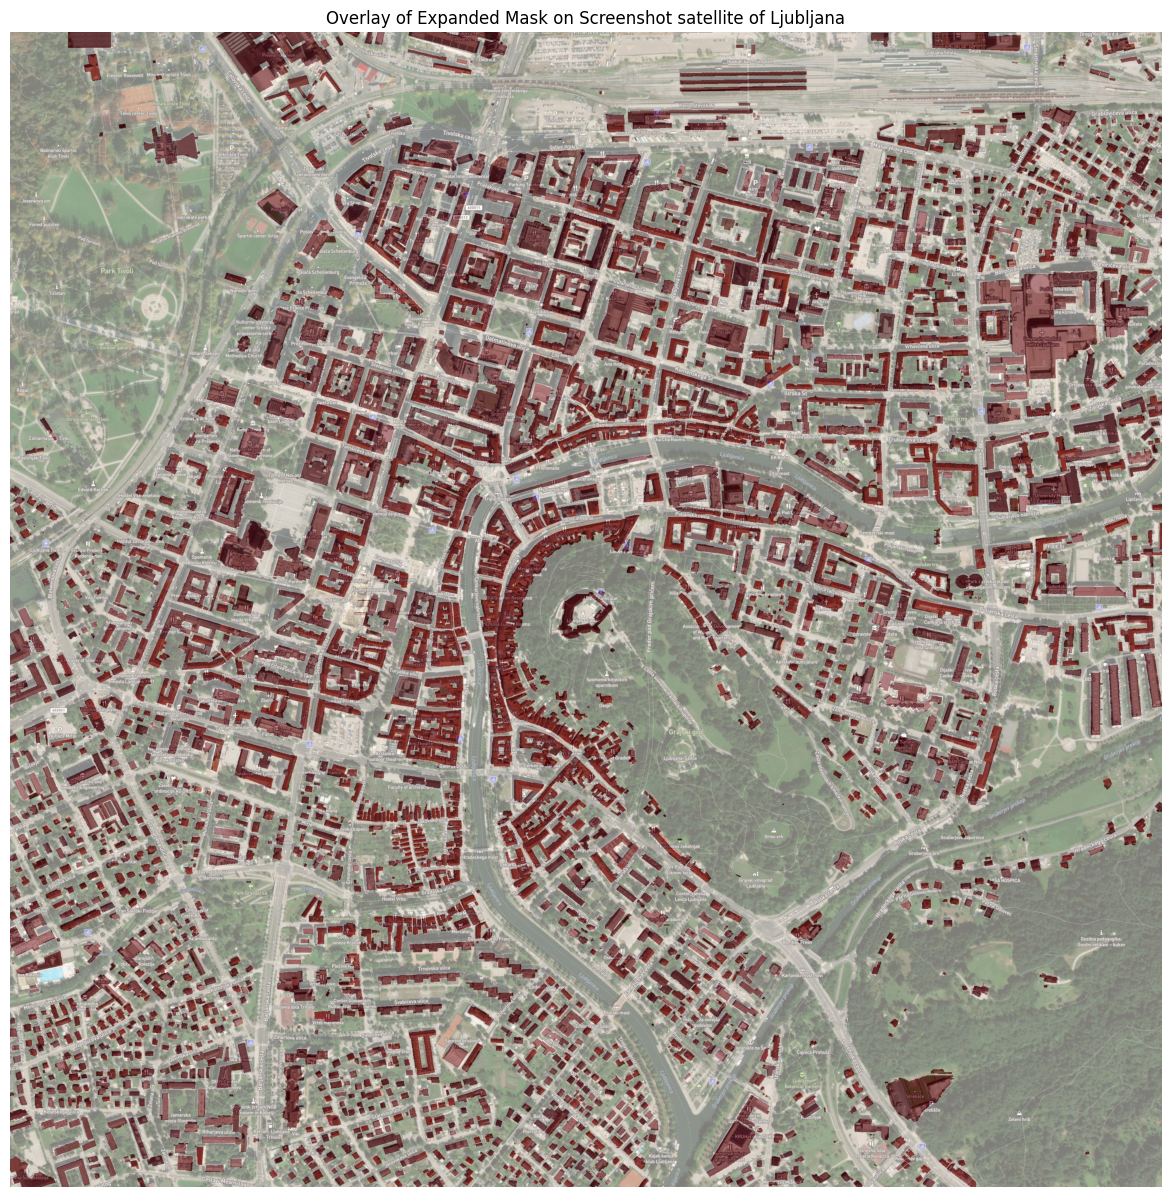

In [8]:
satellite_path = "/content/drive/MyDrive/Education/University/Master/BSML/cropped_satellite_Ljubljana.png"
satellite = Image.open(satellite_path)

mask_path = "/content/drive/MyDrive/Education/University/Master/BSML/cropped_mask_Ljubljana.png"
mask = Image.open(mask_path)

# Convert the screenshot to an array for overlay
satellite_array = np.array(satellite)
mask_array = np.array(mask)

# Plot the screenshot and the resized mask overlay
plt.figure(figsize=(15, 15))
plt.imshow(satellite_array)  # Display the screenshot
plt.imshow(mask_array, cmap="Reds", alpha=0.5)  # Overlay the resized mask in red
plt.title("Overlay of Expanded Mask on Screenshot satellite of Ljubljana")
plt.axis("off")
plt.show()

In [ ]:
def sliding_window_crop(image_path, output_folder, crop_size, step, prefix, counter_start=1):
    """
    Splits an image into smaller images using a sliding window.

    Args:
        image_path (str): Path to the image to be split.
        output_folder (str): Path to the folder where the crops will be saved.
        crop_size (tuple): Size of the crops (width, height).
        step (int): Step size for sliding the window.
        prefix (str): Prefix for naming the saved images.
        counter_start (int): Starting number for naming crops.
    Returns:
        int: Final crop counter for consistent numbering.
    """
    # Open the image
    image = Image.open(image_path)
    width, height = image.size
    crop_width, crop_height = crop_size

    # Create the output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Initialize crop counter
    crop_counter = counter_start

    # Perform sliding window cropping
    for y in range(0, height - crop_height + 1, step):  # Slide vertically
        for x in range(0, width - crop_width + 1, step):  # Slide horizontally
            # Define the crop box (left, upper, right, lower)
            crop_box = (x, y, x + crop_width, y + crop_height)

            # Crop the image
            cropped_image = image.crop(crop_box)

            # Save the cropped image
            cropped_image.save(os.path.join(output_folder, f"{prefix}_{crop_counter}.png"))

            # Increment crop counter
            crop_counter += 1

    print(f"Finished cropping {prefix}. Total crops: {crop_counter - counter_start}")
    return crop_counter  # Return the last crop number


# Paths to the satellite and mask images
satellite_path = "/content/drive/MyDrive/ComputerVisionProject_Group_Due/cropped_satellite_Milano.png"
mask_path = "/content/drive/MyDrive/ComputerVisionProject_Group_Due/cropped_mask_Milano.png"

def crop(city): # 'Milano' or 'Ljubljana'
  # Output folders
  output_folder_satellite = f"/content/drive/MyDrive/ComputerVisionProject_Group_Due/satellite_folder_{city}"
  output_folder_mask = f"/content/drive/MyDrive/ComputerVisionProject_Group_Due/mask_folder_{city}"

  # Sliding window parameters
  crop_size = (200, 200)  # Crop size (width, height)
  step = 25  # Step size for sliding

  # Ensure numbering consistency between mask and satellite crops
  crop_counter_start = 1

  # Crop and save satellite images
  satellite_last_counter = sliding_window_crop(
      satellite_path,
      output_folder_satellite,
      crop_size,
      step,
      "satellite",
      counter_start=crop_counter_start
  )

  # Crop and save mask images, starting with the same counter
  mask_last_counter = sliding_window_crop(
      mask_path,
      output_folder_mask,
      crop_size,
      step,
      "mask",
      counter_start=crop_counter_start
  )

  if satellite_last_counter == mask_last_counter:
      print("Both satellite and mask images have matching crop numbers.")
  else:
      print("Warning: Crop numbers between satellite and mask images do not match!")

crop('Milano')
crop('Ljubljana')

Finished cropping satellite. Total crops: 4469
Finished cropping mask. Total crops: 4469
Both satellite and mask images have matching crop numbers.
Finished cropping satellite. Total crops: 4469
Finished cropping mask. Total crops: 4469
Both satellite and mask images have matching crop numbers.


## Image to Array -> It may take a lot of time


In [ ]:
# Load dataset
def load_data(mask_folder, satellite_folder):
    mask_images = []
    satellite_images = []
    for filename in sorted(os.listdir(mask_folder)):
        mask_path = os.path.join(mask_folder, filename)

        mask = img_to_array(load_img(mask_path, color_mode="grayscale", target_size=(IMG_HEIGHT, IMG_WIDTH)))
        mask = mask / 255.0  # Normalize to 0-1
        mask_images.append(mask)

    for filename in sorted(os.listdir(satellite_folder)):
        satellite_path = os.path.join(satellite_folder, filename)

        satellite = img_to_array(load_img(satellite_path, target_size=(IMG_HEIGHT, IMG_WIDTH)))
        satellite = satellite / 255.0  # Normalize to 0-1
        satellite_images.append(satellite)

    return np.array(satellite_images), np.array(mask_images)

def train_model(city):
  # Define paths
  mask_folder = f"/content/drive/MyDrive/ComputerVisionProject_Group_Due/mask_folder_{city}"
  satellite_folder = f"/content/drive/MyDrive/ComputerVisionProject_Group_Due/satellite_folder_{city}"

  # Image dimensions
  IMG_HEIGHT = 200
  IMG_WIDTH = 200
  IMG_CHANNELS = 3

  # Load the data
  X, y = load_data(mask_folder, satellite_folder)
  np.save(f'X_{city}.npy', X)
  np.save(f'y_{city}.npy', y)

train_model('Milano')
train_model('Ljubljana')

In [ ]:
X_train = np.load('X_Ljubljana.npy')
y_train = np.load('y_Ljubljana.npy')
X_Milano = np.load('X_Milano.npy')
y_Milano = np.load('y_Milano.npy')

In [ ]:
test_indices = np.arange(0, int(len(X_Milano) * 0.5))
val_indices = np.arange(int(len(X_Milano) * 0.5), len(X_Milano))

X_val, y_val = X_Milano[val_indices], y_Milano[val_indices]
X_test, y_test = X_Milano[test_indices], y_Milano[test_indices]

In [ ]:
np.save('X_test.npy', X_test)
np.save('y_test.npy', y_test)
np.save('X_train.npy', X_train)
np.save('y_train.npy', y_train)
np.save('X_val.npy', X_val)
np.save('y_val.npy', y_val)

In [ ]:
X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')
X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')
X_val = np.load('X_val.npy')
y_val = np.load('y_val.npy')

In [ ]:
print("Train:", X_train.shape, y_train.shape)
print("Validation:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)

## Training the model -> It may take a lot of time



In [ ]:
# IoU Metric
def iou_metric(y_true, y_pred):
    """
    Computes the Intersection over Union (IoU) metric.
    """
    y_pred = tf.cast(y_pred > 0.5, dtype=tf.float32)  # Apply threshold to predictions
    intersection = K.sum(y_true * y_pred, axis=[1, 2, 3])
    union = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3]) - intersection
    iou = K.mean((intersection + 1e-7) / (union + 1e-7), axis=0)  # Smooth to avoid division by zero
    return iou

# Dice Loss Function
def dice_loss(y_true, y_pred):
    """
    Computes the Dice loss for binary segmentation.
    """
    smooth = 1e-7
    intersection = K.sum(y_true * y_pred, axis=[1, 2, 3])
    union = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3])
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice

# U-Net Model
def unet_model(input_shape):
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    c3 = BatchNormalization()(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    c4 = BatchNormalization()(c4)

    # Decoder
    u5 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = concatenate([u5, c3])
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u5)
    c5 = BatchNormalization()(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    c5 = BatchNormalization()(c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c2])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = BatchNormalization()(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    c6 = BatchNormalization()(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c1])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    c7 = BatchNormalization()(c7)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c7)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Build and compile the model
IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS = 200, 200, 3
model = unet_model((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
model.compile(optimizer=Adam(learning_rate=1e-3), loss=dice_loss, metrics=['accuracy', iou_metric])

# Save every epoch
checkpoint_callback = ModelCheckpoint(
    filepath='/content/drive/MyDrive/ComputerVisionProject_Group_Due/model_epoch_10.keras',
    save_weights_only=False,
    save_best_only=False,  # Save every epoch
    save_freq='epoch',
    verbose=1
)

# Learning rate scheduler
lr_schedule = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

In [ ]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=16,
    shuffle=True,
    callbacks=[checkpoint_callback, lr_schedule, early_stopping]
)

# Evaluate the model on the test set
test_loss, test_accuracy, test_iou = model.evaluate(X_test, y_test, batch_size=16)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test IoU: {test_iou}")

In [ ]:
# Load the model
model_path = 'model_epoch_02.keras'  # Replace with your actual saved model path
model = load_model(model_path, custom_objects={'dice_loss': dice_loss, 'iou_metric': iou_metric})

# Optionally recompile the model (if optimizer or loss needs to change)
model.compile(optimizer=Adam(learning_rate=1e-4), loss=dice_loss, metrics=['accuracy', iou_metric])

# Continue training
history_continued = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,  # Number of additional epochs
    batch_size=16,
    shuffle=True,
    callbacks=[checkpoint_callback, lr_schedule, early_stopping]
)

# Re-evaluate the model after additional training3542werqì'
test_loss, test_accuracy, test_iou = model.evaluate(X_test, y_test, batch_size=16)
print(f"Continued Test Loss: {test_loss}")
print(f"Continued Test Accuracy: {test_accuracy}")
print(f"Continued Test IoU: {test_iou}")


Epoch 1/20
743/743 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9347 - iou_metric: 0.7275 - loss: 0.1947
Epoch 1: saving model to model_epoch_01.keras
743/743 ━━━━━━━━━━━━━━━━━━━━ 5766s 8s/step - accuracy: 0.9347 - iou_metric: 0.7275 - loss: 0.1947 - val_accuracy: 0.6180 - val_iou_metric: 0.5046 - val_loss: 0.3569 - learning_rate: 1.0000e-04
Epoch 2/20
743/743 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9428 - iou_metric: 0.7593 - loss: 0.1786
Epoch 2: saving model to model_epoch_02.keras
743/743 ━━━━━━━━━━━━━━━━━━━━ 5671s 8s/step - accuracy: 0.9428 - iou_metric: 0.7593 - loss: 0.1786 - val_accuracy: 0.6244 - val_iou_metric: 0.4969 - val_loss: 0.3625 - learning_rate: 1.0000e-04
Epoch 3/20
743/743 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9479 - iou_metric: 0.7744 - loss: 0.1679
Epoch 3: saving model to model_epoch_03.keras
743/743 ━━━━━━━━━━━━━━━━━━━━ 5653s 8s/step - accuracy: 0.9479 - iou_metric: 0.7744 - loss: 0.1679 - val_accuracy: 0.6418 - val_iou_metric: 0.5074 - val_loss: 


KeyboardInterrupt

